In [1]:
from lfads_tf2.utils import load_data, load_posterior_averages
import src.data
import src.lfads_helpers
import src.util
import pyaldata
import yaml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import k3d
import numpy as np
from src.models import SSA
import seaborn as sns

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    full_params = yaml.safe_load(params_file)
    lfads_params = full_params['lfads_prep']
    analysis_params = full_params['analysis']

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params,analysis_params)

start_time = -1.0
end_time = 5.0
td_cst = pyaldata.restrict_to_interval(
    td_cst,
    start_point_name='idx_goCueTime',
    rel_start=int(start_time/td_cst.loc[td_cst.index[0],'bin_size']),
    rel_end=int(end_time/td_cst.loc[td_cst.index[0],'bin_size']),
    reset_index=False
)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 67 182 219 220 255 312 339 522]
  app.launch_new_instance()


In [5]:
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='CST smoothed neural traces')
max_abs_hand_vel = np.percentile(np.abs(np.row_stack(td_cst['hand_vel'])[:,0]),95)
# plot traces
for _,trial in td_cst.sample(n=10).iterrows():
    neural_trace = trial['M1_pca']
    # trace_plot+=k3d.line(neural_trace[:,0:3].astype(np.float32),shader='mesh',width=0.2,attribute=trial['hand_vel'][:,0],color_map=k3d.matplotlib_color_maps.PiYG)
    trace_plot+=k3d.line(
        neural_trace[:,0:3].astype(np.float32),
        shader='mesh',
        width=0.25,
        attribute=trial['hand_vel'][:,0],
        color_map=k3d.paraview_color_maps.Erdc_divHi_purpleGreen,
        color_range=[-max_abs_hand_vel,max_abs_hand_vel],
    )

# trace_plot+=k3d.line(td_cst['M1_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=0)

trace_plot.display()


Output()

In [4]:
# fig,ax = plt.subplots()
trace_plot = k3d.plot(name='CST LFADS neural traces')
max_abs_hand_vel = np.percentile(np.abs(np.row_stack(td_cst['hand_vel'])[:,0]),95)
# plot traces
for _,trial in td_cst.sample(n=10).iterrows():
    neural_trace = trial['lfads_pca']
    trace_plot+=k3d.line(
        neural_trace[:,0:3].astype(np.float32),
        shader='mesh',
        width=0.25,
        attribute=trial['hand_vel'][:,0],
        color_map=k3d.paraview_color_maps.Erdc_divHi_purpleGreen,
        color_range=[-max_abs_hand_vel,max_abs_hand_vel],
    )

# trace_plot+=k3d.line(td_cst['lfads_pca'].mean()[:,0:3].astype(np.float32),shader='mesh',width=1,color=0)

trace_plot.display()



Output()

Text(0.5, 1.0, 'LFADS PCA')

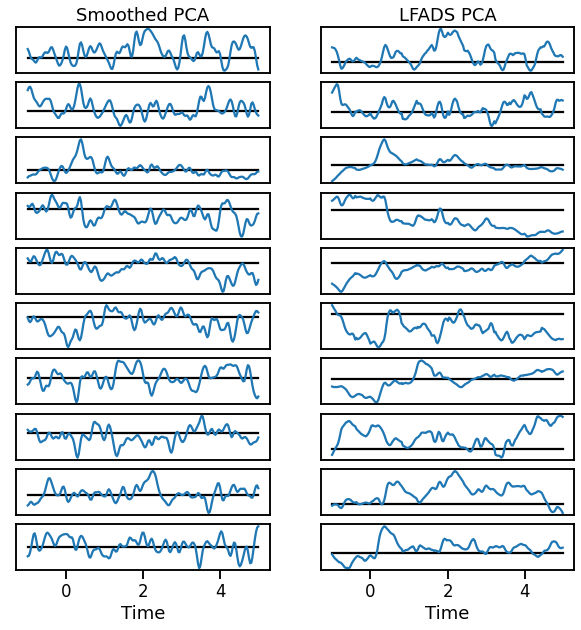

In [6]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
trial = td_cst.iloc[5,:]
num_dims = analysis_params['num_dims']

plt.figure(figsize=(10,10))
for i in range(num_dims):
    
    # Plot SSA results
    plt.subplot(num_dims,2,2*i+1)
    plt.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
    plt.plot(trial['trialtime'],trial['M1_pca'][:,i])
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<num_dims-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(num_dims,2,2*i+2)
    plt.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
    plt.plot(trial['trialtime'],trial['lfads_pca'][:,i])
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<num_dims-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

#Titles
plt.subplot(num_dims,2,1)
plt.title('Smoothed PCA')

plt.subplot(num_dims,2,2)
plt.title('LFADS PCA')


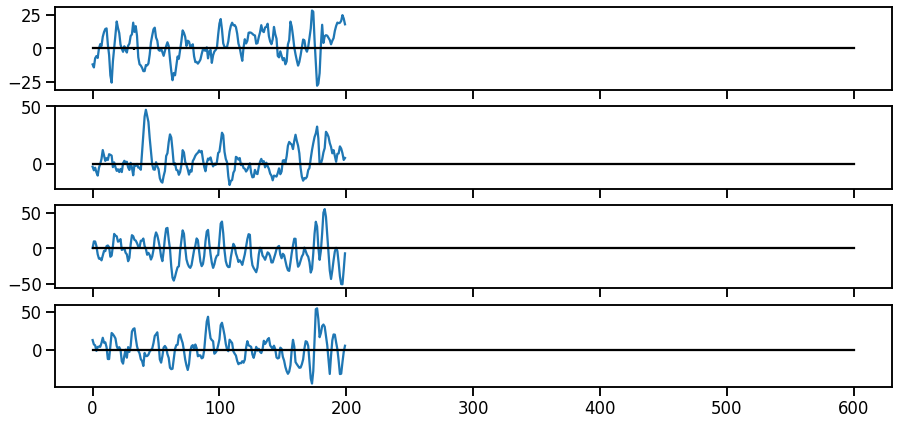

In [8]:
fig,axs = plt.subplots(4,1,figsize=(15,7),sharex=True)
trial = td_cst.sample(n=1).squeeze()

for plotnum,ax in enumerate(axs):
    ax.plot(trial['lfads_inputs'][:,plotnum])
    ax.plot([0,600],[0,0],color='k')
    ax.plot(trial['idx_goCueTime']*np.ones((2,)),[-1,1],'k--')

In [9]:
num_dims = 10
M1_ssa_model = SSA(R=num_dims,n_epochs=3000,lr=0.01)
td_cst = pyaldata.dim_reduce(td_cst,M1_ssa_model,'M1_rates','M1_ssa')

lfads_ssa_model = SSA(R=num_dims,n_epochs=3000,lr=0.01)
td_cst = pyaldata.dim_reduce(td_cst,lfads_ssa_model,'lfads_rates','lfads_ssa')


Using lam_sparse=  2.6970530379947806
Using device cuda:0


100%|██████████| 3000/3000 [00:20<00:00, 146.34it/s]


Using lam_sparse=  0.229505468548707
Using device cuda:0


100%|██████████| 3000/3000 [00:20<00:00, 145.34it/s]


Text(0.5, 0, 'Training Epoch')

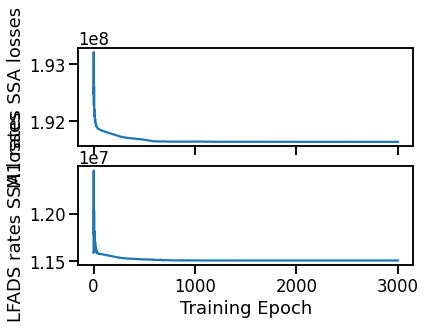

In [10]:
fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(M1_ssa_model.losses)
axs[0].set_ylabel('M1 rates SSA losses')
axs[1].plot(lfads_ssa_model.losses)
axs[1].set_ylabel('LFADS rates SSA losses')
axs[1].set_xlabel('Training Epoch')


Text(0.5, 1.0, 'PCA LowD Projections')

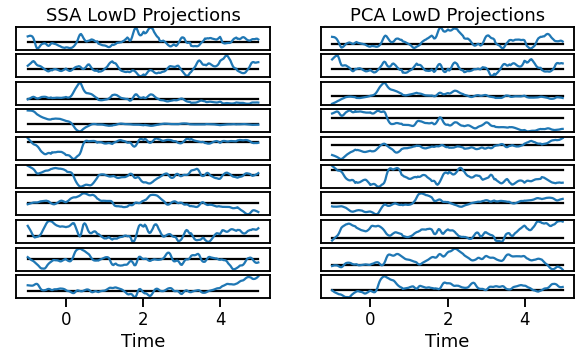

In [11]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
trial = td_cst.iloc[5,:]

plt.figure(figsize=(10,5))
for i in range(num_dims):
    
    # Plot SSA results
    plt.subplot(num_dims,2,2*i+1)
    plt.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
    plt.plot(trial['trialtime'],trial['lfads_ssa'][:,i])
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<num_dims-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(num_dims,2,2*i+2)
    plt.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
    plt.plot(trial['trialtime'],trial['lfads_pca'][:,i])
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<num_dims-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

#Titles
plt.subplot(num_dims,2,1)
plt.title('SSA LowD Projections')

plt.subplot(num_dims,2,2)
plt.title('PCA LowD Projections')


In [12]:
from ipywidgets import interact
# plot out SSA projections and hand/cursor movement
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
# trial = td_cst.sample(n=1).squeeze()

@interact(trial_id = list(td_cst['trial_id']), signal = ['lfads_ssa','lfads_gen_inputs'])
def plot_trial_ssa(trial_id,signal):
    trial = td_cst.loc[td_cst['trial_id']==trial_id,:].squeeze()
    num_dims = trial[signal].shape[1]
    fig,axs = plt.subplots(num_dims+1,1,figsize=(5,10),sharex=True)
    for i,ax in enumerate(axs):
        # ax.clear() 
        if i<num_dims:
            # Plot SSA results
            ax.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
            ax.plot(trial['trialtime'],trial[signal][:,i])
            ax.set_yticks([])
            # ax.set_ylim([-1,1])
            ax.set_ylabel('{}'.format(i))
        else:
            ax.plot(trial['trialtime'][[0,-1]],[0,0],color='k')
            ax.plot(trial['trialtime'],trial['rel_hand_pos'][:,0],'r')
            ax.plot(trial['trialtime'],trial['rel_cursor_pos'][:,0],'b')
            ax.set_yticks([])
            ax.set_xlabel('Time')

        ax.plot([0,0],ax.get_ylim(),color='k',linestyle='--')

    sns.despine(fig=fig,left=True,bottom=True,trim=True)
    
#     plt.ylim([-1.1, 1.1])

#Titles
# plt.subplot(num_dims,2,1)
# plt.title('SSA LowD Projections')
# 
# plt.subplot(num_dims,2,2)
# plt.title('PCA LowD Projections')


interactive(children=(Dropdown(description='trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 20, 2…

: 

In [ ]:
lfads_ssa_model.save_model_to_file('../results/ssa/Earl_20190716_CST_lfads_ssa_model.pt')